[ 7  9 19 27  6 49 28 21 44 23 43 12 31 20 45 26  6 13 33 10]


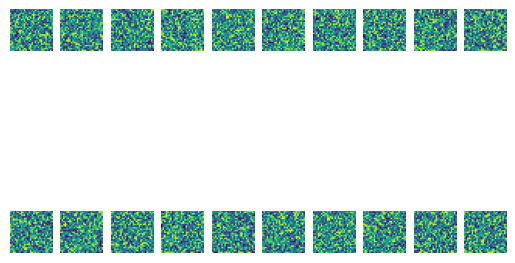

Epoch [1/2], Step [100/600], Loss: 1.7616
Epoch [1/2], Step [200/600], Loss: 1.3445
Epoch [1/2], Step [300/600], Loss: 1.2222
Epoch [1/2], Step [400/600], Loss: 1.0187
Epoch [1/2], Step [500/600], Loss: 0.8280
Epoch [1/2], Step [600/600], Loss: 0.6707
Epoch [2/2], Step [100/600], Loss: 0.7026
Epoch [2/2], Step [200/600], Loss: 0.6260
Epoch [2/2], Step [300/600], Loss: 0.5745
Epoch [2/2], Step [400/600], Loss: 0.6576
Epoch [2/2], Step [500/600], Loss: 0.4569
Epoch [2/2], Step [600/600], Loss: 0.4225
Accuracy of the network on the 10000 test images: 88.16 %


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
input_size = 784 # 28x28
hidden_size = 50
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.005

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

class Gaussian(nn.Module):
    def __init__(self, input_size, output_size):
        super(Gaussian, self).__init__()
        self.input_size = input_size
        self.output_size = output_size 
        self.layer = nn.Linear(input_size, output_size)

    def forward(self, x):
        W, bias = self.parameters() # we will not use bias
        n, dw = W.shape
        m, dx = x.shape 
        assert dw==dx
        x_reshaped = x.view(m, 1, dx)
        W_reshaped = W.view(1, n, dw)
        dist = (x_reshaped - W_reshaped).norm(dim=2)
        w = 6 # = 75% * torch.abs(dist).max()
        # gauss = torch.pow(2, -dist**2/w**2)
        gauss = torch.exp(-dist**2/w**2)
        # gauss = dist
        # print(gauss.shape)
        return gauss

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = Gaussian(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        # out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

import numpy as np
model_state_dict = model.state_dict()
W = model_state_dict['l1.layer.weight']
np.random.seed(103)
n_images = 20
indices = np.random.choice(range(W.shape[0]), n_images)
print(indices)
for i in range(n_images):
    plt.subplot(2,n_images//2,i+1)
    plt.imshow(W[indices[i]].reshape(28, 28))
    # plt.title(f"i={i}")
    plt.axis("off")
plt.show()


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        flat_images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(flat_images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')


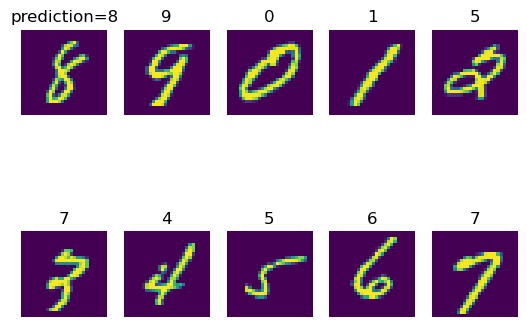

In [3]:
for i in range(10):
    lab = labels[i].item()
    pred = predicted[i].item()
    plt.subplot(2,5,i+1)
    plt.imshow(images[i][0])
    plt.title(f"prediction={pred}" if i==0 else f"{pred}")
    plt.axis("off")
plt.show()

[ 7  9 19 27  6 49 28 21 44 23 43 12 31 20 45 26  6 13 33 10]


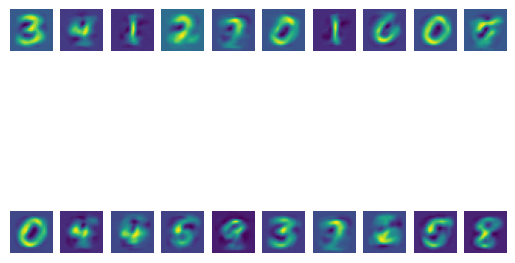

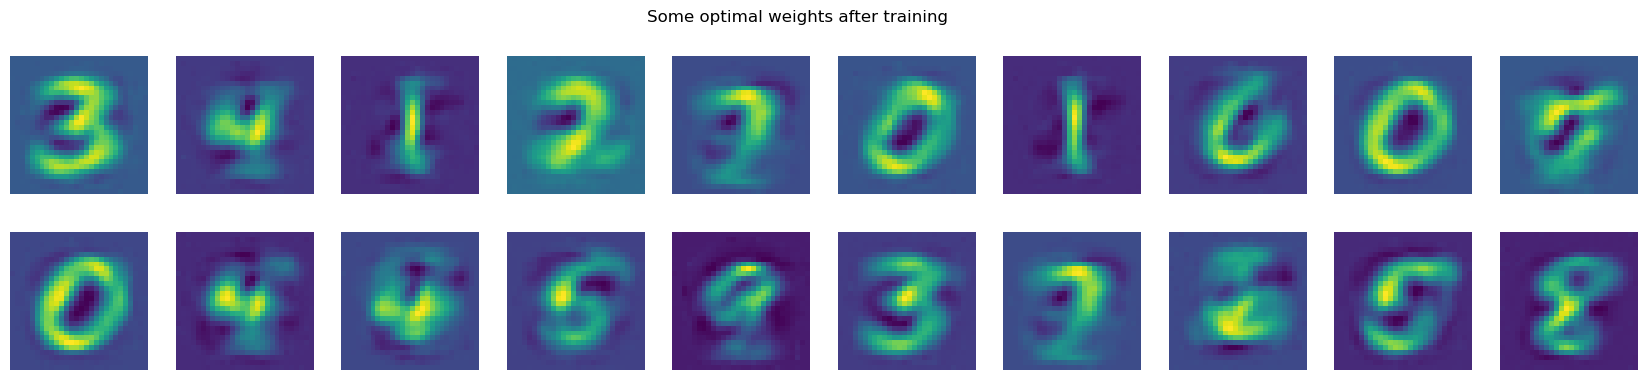

In [4]:
# Access the model's state dictionary
import numpy as np
model_state_dict = model.state_dict()
W = model_state_dict['l1.layer.weight']
np.random.seed(103)

nrows = 2
ncols = 10
n_images = nrows * ncols
indices = np.random.choice(range(W.shape[0]), n_images).reshape(nrows, ncols)


fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.1, nrows*2.1))
for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        ax.imshow(W[indices[i, j]].reshape(28, 28))
        ax.axis("off")
fig.suptitle(f"Some optimal weights after training")
plt.show()
